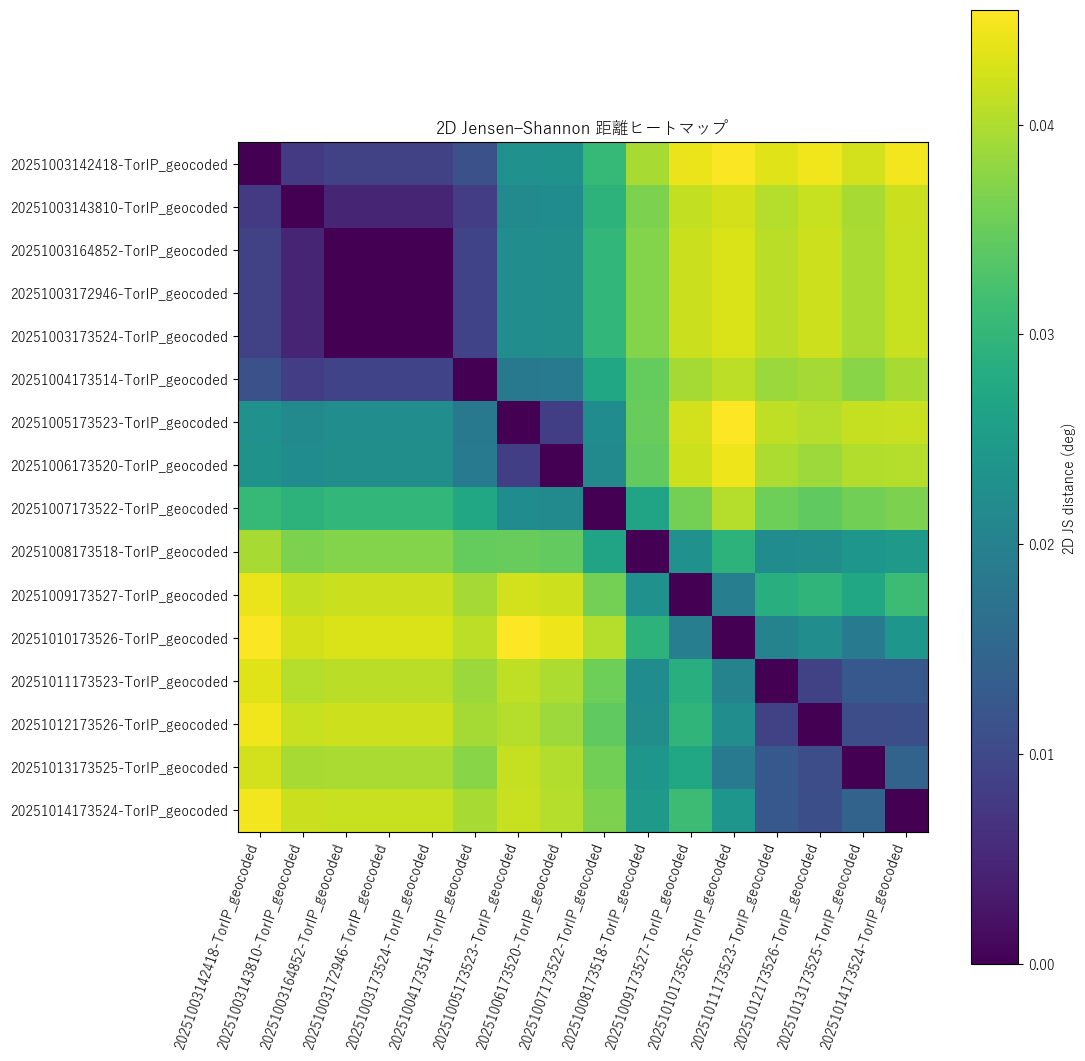

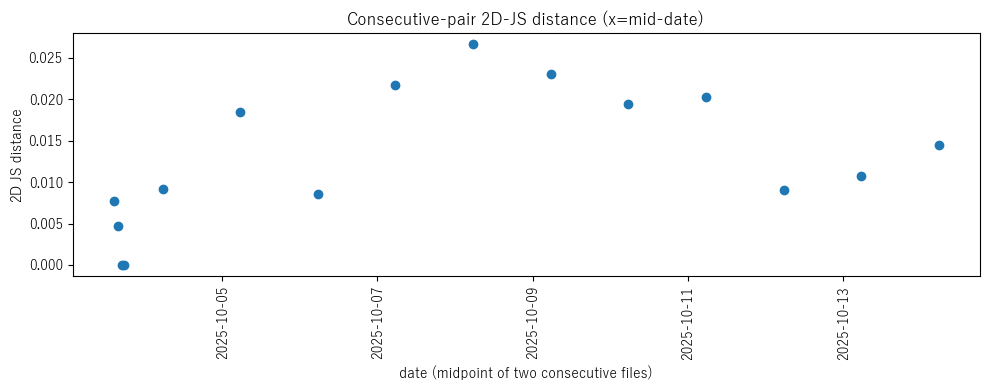

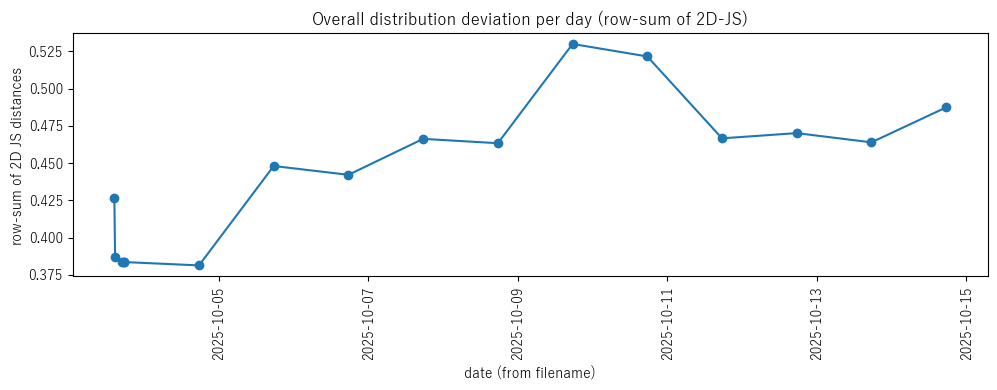

✅ 出力完了（JS距離）
   jsdist_matrix.csv
   jsdist_files.txt
   jsdist_timeseries.csv
   jsdist_heatmap.png
   jsdist_timeseries.png
   jsdist_row_sums.png


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Jensen–Shannon 距離（JS距離）版
- isolation_forest.zip を自動解凍して *-TorIP_geocoded.csv を処理
- (1) 全ファイル間 2D-JS 距離行列 (CSV/PNG)
- (2) 隣接ペア 2D-JS 距離の時系列 (CSV/PNG)
- (3) 距離行列の行総和（総乖離度）(PNG)

※ 2D-JS 距離は、緯度と経度の 1D-JS 距離を RMS 合成
※ 1D はヒストグラムで確率化（スムージング付き）
※ 図は matplotlib のみ、CSV出力は cp932（Shift_JIS）
"""

# ========= 設定 =========
ZIP_PATH        = "./isolation_forest.zip"
EXTRACT_DIR     = "./isolation_forest_extracted"
PREFIX          = "jsdist"      # 出力プレフィックス
UNIT            = "deg"         # "deg" or "km"（km換算する場合は "km"）
MIN_ROWS        = 1             # 各CSVの最小有効行数
Z_THR_TS        = 3.5           # 時系列のロバストZ閾値
OUTPUT_ENCODING = "cp932"       # "utf-8-sig" も可

# JS距離のヒストグラム推定パラメータ
BINS            = 64            # ビン数（64〜128程度が目安）
RANGE_MODE      = "pooled"      # "pooled"＝全データの最小最大を共有レンジに
EPS_SMOOTH      = 1e-12         # ゼロ回避の平滑化

# 日本語フォント候補（環境に応じて自動選択）
JP_FONT_CANDIDATES = ["Yu Gothic", "Meiryo", "Noto Sans CJK JP", "IPAexGothic", "IPAPGothic", "TakaoGothic"]
# =======================

import os, sys, csv, math, zipfile, shutil
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager, rcParams

# ---------- フォント ----------
def setup_japanese_font():
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in JP_FONT_CANDIDATES:
        if name in available:
            rcParams["font.family"] = "sans-serif"
            rcParams["font.sans-serif"] = [name]
            break
    rcParams["axes.unicode_minus"] = False

# ---------- 文字コード ----------
READ_ENCODINGS = ("utf-8", "utf-8-sig", "cp932", "iso-8859-1")
def open_read_fallback(path):
    last = None
    for enc in READ_ENCODINGS:
        try:
            return open(path, "r", encoding=enc, newline="")
        except Exception as e:
            last = e
    try:
        return open(path, "r", newline="")
    except Exception:
        raise last or RuntimeError(f"cannot open {path}")

TRANSLATE_TABLE = {
    0x2010: ord("-"), 0x2011: ord("-"), 0x2012: ord("-"), 0x2013: ord("-"),
    0x2014: ord("-"), 0x2015: ord("-"), 0x2212: ord("-"),
    0x00A0: ord(" ")
}
def normalize_text(s: str) -> str:
    return s.translate(TRANSLATE_TABLE) if isinstance(s, str) else s

def open_write(path):
    return open(path, "w", encoding=OUTPUT_ENCODING, newline="", errors="replace")

# ---------- CSV読込 ----------
def row_has_header_like(cells):
    if len(cells) < 4: return True
    try:
        float((cells[2] or "").strip()); float((cells[3] or "").strip())
        return False
    except Exception:
        return True

def load_valid_latlon(filepath):
    lats, lons = [], []
    with open_read_fallback(filepath) as f:
        rdr = csv.reader(f)
        first = next(rdr, None)
        if first is None: return np.empty(0), np.empty(0)
        use_header = row_has_header_like(first)
        rows_iter = rdr if use_header else [first] + list(rdr)
        for row in rows_iter:
            if len(row) < 4: continue
            a = (row[2] or "").strip(); b = (row[3] or "").strip()
            if not a or not b: continue
            try:
                lat = float(a); lon = float(b)
                if math.isfinite(lat) and math.isfinite(lon):
                    lats.append(lat); lons.append(lon)
            except Exception:
                continue
    return np.array(lats, float), np.array(lons, float)

# ---------- 単位換算 ----------
def deg_to_km_scale(lat_values):
    phi = (float(np.median(lat_values)) if len(lat_values) else 0.0) * math.pi/180.0
    return 111.32, 111.32 * math.cos(phi)

def convert_unit(lat_array, lon_array, ref_lat=None):
    if UNIT != "km":
        return lat_array, lon_array
    ref = ref_lat if ref_lat is not None else np.median(lat_array) if len(lat_array) else 0.0
    la_km, lo_km = deg_to_km_scale(np.array([ref]))
    return lat_array * la_km, lon_array * lo_km

# ---------- JS距離（1D） ----------
def _kl_div(p, q):
    # KL(p||q) with handling zeros; p,q are probability vectors (>0)
    return np.sum(p * (np.log(p) - np.log(q)))

def js_distance_1d(samples_a, samples_b, bins, value_range):
    # ヒストグラムで確率ベクトル化（正規化＋平滑化）
    pa, _ = np.histogram(samples_a, bins=bins, range=value_range, density=False)
    pb, _ = np.histogram(samples_b, bins=bins, range=value_range, density=False)
    pa = pa.astype(float); pb = pb.astype(float)
    pa = (pa + EPS_SMOOTH); pb = (pb + EPS_SMOOTH)
    pa /= pa.sum(); pb /= pb.sum()
    m = 0.5 * (pa + pb)
    # JS divergence (base e), distance = sqrt(JSD)
    jsd = 0.5 * _kl_div(pa, m) + 0.5 * _kl_div(pb, m)
    return float(np.sqrt(max(jsd, 0.0)))

# ---------- 2D 合成 ----------
def composite_js_distance_2d(lat_a, lon_a, lat_b, lon_b, bins_lat, range_lat, bins_lon, range_lon):
    # UNIT 換算（kmのとき尺度を反映）
    ref_lat = np.median(np.concatenate([lat_a, lat_b])) if (len(lat_a)+len(lat_b)) else 0.0
    lat_a2, lon_a2 = convert_unit(lat_a, lon_a, ref_lat)
    lat_b2, lon_b2 = convert_unit(lat_b, lon_b, ref_lat)
    d_lat = js_distance_1d(lat_a2, lat_b2, bins_lat, range_lat)
    d_lon = js_distance_1d(lon_a2, lon_b2, bins_lon, range_lon)
    return float(np.hypot(d_lat, d_lon))

# ---------- ロバストZ ----------
def robust_zscore(x: np.ndarray) -> np.ndarray:
    if x.size == 0: return np.zeros(0, float)
    med = np.median(x); mad = np.median(np.abs(x - med))
    if mad == 0: return np.zeros_like(x, float)
    return 0.6745 * (x - med) / mad

# ---------- ファイル名日時 ----------
def date_from_filename(fname: str):
    base = os.path.basename(fname)
    key = base.split("-")[0]
    try:
        dt = datetime.strptime(key[:14], "%Y%m%d%H%M%S")
        return dt.date(), dt
    except Exception:
        return None

# ---------- メイン ----------
def main():
    setup_japanese_font()

    # zip 展開
    if os.path.exists(EXTRACT_DIR):
        shutil.rmtree(EXTRACT_DIR)
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    if not os.path.exists(ZIP_PATH):
        print(f"[ERROR] zipが見つかりません: {ZIP_PATH}", file=sys.stderr); return
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)

    # 対象CSV探索
    csv_files = []
    for root, _, files in os.walk(EXTRACT_DIR):
        for f in files:
            if f.endswith("TorIP_geocoded.csv"):
                csv_files.append(os.path.join(root, f))
    if len(csv_files) < 2:
        print("[ERROR] 有効CSVが2件未満です。", file=sys.stderr); return

    # 読み込み
    recs = []  # (day, dt_full, path, lats, lons)
    for f in sorted(csv_files):
        d = date_from_filename(f)
        if d is None:
            print(f"[WARN] 日付抽出に失敗: {f}", file=sys.stderr); continue
        day, dt_full = d
        lats, lons = load_valid_latlon(f)
        if len(lats) >= MIN_ROWS and len(lons) >= MIN_ROWS:
            recs.append((day, dt_full, f, lats, lons))
        else:
            print(f"[WARN] 有効行不足: {f}", file=sys.stderr)
    if len(recs) < 2:
        print("[ERROR] 有効データが2件未満です。", file=sys.stderr); return

    # 日時で整列
    recs.sort(key=lambda t: t[1])
    base_names = [os.path.splitext(os.path.basename(r[2]))[0] for r in recs]
    n = len(recs)

    # ----- ヒストグラムのレンジ設定（pooled推奨） -----
    all_lat = np.concatenate([r[3] for r in recs]) if RANGE_MODE=="pooled" else None
    all_lon = np.concatenate([r[4] for r in recs]) if RANGE_MODE=="pooled" else None
    if UNIT == "km":
        # km換算のため lat中心を全体中央値で決定
        ref_lat = float(np.median(all_lat)) if all_lat is not None and len(all_lat) else 0.0
        all_lat_km, all_lon_km = convert_unit(all_lat if all_lat is not None else np.array([]),
                                              all_lon if all_lon is not None else np.array([]),
                                              ref_lat)
        lat_vals = all_lat_km if RANGE_MODE=="pooled" else None
        lon_vals = all_lon_km if RANGE_MODE=="pooled" else None
    else:
        lat_vals = all_lat if RANGE_MODE=="pooled" else None
        lon_vals = all_lon if RANGE_MODE=="pooled" else None

    def pad_range(x):
        if x is None or x.size == 0: return (-1.0, 1.0)
        lo, hi = float(np.min(x)), float(np.max(x))
        if lo == hi:
            span = 1.0 if lo == 0 else abs(lo)*0.01
            lo -= span; hi += span
        pad = (hi - lo) * 0.02
        return (lo - pad, hi + pad)

    range_lat = pad_range(lat_vals) if RANGE_MODE=="pooled" else None
    range_lon = pad_range(lon_vals) if RANGE_MODE=="pooled" else None

    # ---------- (1) 全ペア 2D-JS 距離行列 ----------
    dist = np.zeros((n, n), float)
    for i in range(n):
        for j in range(i+1, n):
            la_i, lo_i = recs[i][3], recs[i][4]
            la_j, lo_j = recs[j][3], recs[j][4]
            # ペアごとのレンジ（pooled以外ならその都度）
            if RANGE_MODE != "pooled":
                rl = pad_range(np.concatenate([la_i, la_j]))
                ro = pad_range(np.concatenate([lo_i, lo_j]))
            else:
                rl, ro = range_lat, range_lon
            d = composite_js_distance_2d(la_i, lo_i, la_j, lo_j,
                                         BINS, rl, BINS, ro)
            dist[i, j] = dist[j, i] = d

    # 行列CSV（見出し付き）
    matrix_csv = f"{PREFIX}_matrix.csv"
    with open_write(matrix_csv) as w:
        wr = csv.writer(w)
        wr.writerow([""] + [normalize_text(nm) for nm in base_names])
        for i, nm in enumerate(base_names):
            wr.writerow([normalize_text(nm)] + [f"{x:.6f}" for x in dist[i]])

    # 行列のファイル順
    files_txt = f"{PREFIX}_files.txt"
    with open_write(files_txt) as w:
        w.write("\n".join(normalize_text(nm) for nm in base_names))

    # ヒートマップ
    fig = plt.figure(figsize=(max(6, n*0.7), max(5, n*0.7)))
    ax = plt.gca()
    im = ax.imshow(dist, aspect="equal", interpolation="nearest")
    cbar = plt.colorbar(im); cbar.set_label(f"2D JS distance ({UNIT})")
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(base_names, rotation=70, ha="right")
    ax.set_yticklabels(base_names)
    ax.set_title("2D Jensen–Shannon 距離ヒートマップ")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_heatmap.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # ---------- (2) 隣接ペア 時系列 ----------
    dt_full = [r[1] for r in recs]
    x_dates, dist_vals, file_pair = [], [], []
    for i in range(1, n):
        laL, loL = recs[i-1][3], recs[i-1][4]
        laR, loR = recs[i][3],  recs[i][4]
        if RANGE_MODE != "pooled":
            rl = pad_range(np.concatenate([laL, laR]))
            ro = pad_range(np.concatenate([loL, loR]))
        else:
            rl, ro = range_lat, range_lon
        d = composite_js_distance_2d(laL, loL, laR, loR, BINS, rl, BINS, ro)
        dist_vals.append(d)
        mid = dt_full[i-1] + (dt_full[i] - dt_full[i-1]) / 2
        x_dates.append(mid)
        file_pair.append(f"{base_names[i-1]} -> {base_names[i]}")

    x_dates   = np.array(x_dates, dtype=object)
    dist_vals = np.array(dist_vals, float)
    z = robust_zscore(dist_vals)

    ts_csv = f"{PREFIX}_timeseries.csv"
    with open_write(ts_csv) as w:
        wr = csv.writer(w)
        wr.writerow(["date_mid","file_pair","distance_js2d","z"])
        for i in range(len(dist_vals)):
            wr.writerow([
                x_dates[i].strftime("%Y-%m-%d %H:%M:%S"),
                normalize_text(file_pair[i]),
                f"{dist_vals[i]:.6f}",
                f"{z[i]:.3f}",
            ])

    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.plot(x_dates, dist_vals, marker="o", linestyle="none")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (midpoint of two consecutive files)")
    plt.ylabel("2D JS distance")
    plt.title("Consecutive-pair 2D-JS distance (x=mid-date)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_timeseries.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # ---------- (3) 行総和 ----------
    row_sums = dist.sum(axis=1)
    dates_sorted = [r[1] for r in recs]
    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.plot(dates_sorted, row_sums, marker="o")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (from filename)")
    plt.ylabel("row-sum of 2D JS distances")
    plt.title("Overall distribution deviation per day (row-sum of 2D-JS)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_row_sums.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    print("✅ 出力完了（JS距離）")
    print("  ", f"{PREFIX}_matrix.csv")
    print("  ", f"{PREFIX}_files.txt")
    print("  ", f"{PREFIX}_timeseries.csv")
    print("  ", f"{PREFIX}_heatmap.png")
    print("  ", f"{PREFIX}_timeseries.png")
    print("  ", f"{PREFIX}_row_sums.png")

if __name__ == "__main__":
    main()
